In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from gym.envs.classic_control import CartPoleEnv
from rlutils import Agent, enact_policy, evaluate_agent, state_cols
from collections import deque
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

In [21]:
"""Actions/State


        | (0,0) | U/1|  (2,0) |
        |L/4    | X  | R/2    |
        | (0,2) | D/3| (2,2)  |
""" 


class BPFEnv():
    def __init__(self, n_residues_max, residues):
        assert len(residues) <= n_residues_max, "Invalid Protein"
        # self.hyperparameters = ? may need some here
        residues_ = []
        for i in range(len(residues)):
            if(i < len(residues)):
                residues_ += [residues[i]]
            else:
                residues_ += [0]
        self.state = np.array(([0]*(n_residues_max*2 + 1)**2) + residues_ + [n_residues_max, n_residues_max])
        self.n_residues_max = n_residues_max
        # flat representation of the state
    def make_state_pretty(self):
        #convert the flat representation of the state into something more easily useable
        nrm = self.n_residues_max
        grid = self.state[:(2*nrm+1)**2].reshape(2*nrm+1, 2*nrm+1)
        residues = self.state[(2*nrm+1)**2:(2*nrm+1)**2+nrm]
        pos = [self.state[-2], self.state[-1]]
        return (grid, residues, pos)
    def state_from_pretty(self, pretty):
        grid = pretty[0]
        residues = pretty[1]
        pos = pretty[2]
        state_ = np.concatenate([grid.flatten(), residues], axis=0)
        state_ = np.concatenate([state_, pos], axis=0)
        self.state = state_
        
    def increment(self, action):
        # double check the move makes sense
        assert action in [1,2,3,4], "Action " +str(action) + " is invalid"
        
        state_prime = self.make_state_pretty()
        board = state_prime[0]
        residues = state_prime[1]
        position = state_prime[2]
        
        position[0] += (action % 2 ==0) * (np.sign(3-action)) # i.e. if the action is divisible by 2 (right or left) with appropriate sign
        position[1] += (not action%2 == 0) * (np.sign(action-2)) # these lines just move where our cursor is
        board[position[0],position[1]] = residues[0] # change board at cursor to leading residues
        residues = [residues[i] for i in range(1, len(residues))] + [0] # remove first residue
        self.state = np.concatenate([board.flatten(), residues, position], axis=0)
        
    def reset(self):
        return self.state, {}
    def compute_energy(self, state):
        # first attempt at the energy functional
        side_of_board_reward = 0
        energy = 0
        board = state[0]
        for i in range(len(board)):
            for j in range(len(board[i])):
                ep = 0
                if(j < len(board[i])-1):
                    ep += np.abs(board[i][j+1]+board[i][j])
                else:
                    ep += side_of_board_reward
                if(j > 0):
                    ep += np.abs(board[i][j-1]+board[i][j])
                else:
                    ep += side_of_board_reward
                if(i > 0):
                    ep += np.abs(board[i-1][j] + board[i][j])
                else:
                    ep += side_of_board_reward
                if(i < len(board[j]-1)):
                    ep += np.abs(board[i+1][j] + board[i][j])
                else:
                    ep += side_of_board_reward
                # if any of the residues match, they are awarded 2 points. If they are blank, they are awarded 1pt
                # if they are different they are awarded 0 points. We then
                energy += ep
                    
    def step(self, action):
        assert action in [1,2,3,4], "Action " +str(action) + " is invalid"
        
        reward = 0
        new_state = self.increment(action)
        
        #now we need to implement the rewards
        
        #SELF - AVOIDING
        if(not np.count_nonzero(new_state[0]) > np.count_nonzero(state[0])):
            # this means the action overlapped with a previous residue
            reward += 0.01
            done = True
        if(len(self.state[2]) == 0):
            reward += 0.5
            done = True #finished protein
        #ENERGY 
        if(not done):
            reward += self.compute_energy(new_state)
        
        
        return new_state, reward, done, {}

    def show(self):
        # display a picture of the current state
        state_ = self.make_state_pretty()
        x = state_[0]
        green = [[i,j] for i in range(len(x)) for j in range(len(x[i])) if x[i][j] == -1]
        blue =  [[i,j] for i in range(len(x)) for j in range(len(x[i])) if x[i][j] == 1]
        green = np.array(green)
        blue = np.array(blue)
        plt.scatter(green[:,0],green[:,1],color="green", lw=5)
        plt.scatter(blue[:, 0], blue[:, 1],color="teal", lw=5)
        plt.xlim(0,self.n_residues_max*2 +1)
        plt.ylim(0,self.n_residues_max*2 +1)
        plt.grid()
        

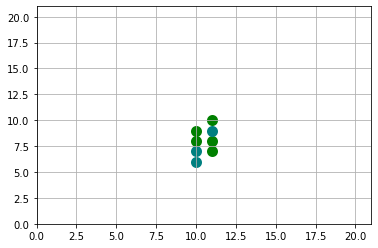

In [25]:
env = BPFEnv(10, [-1,1,-1,1,1,-1,-1,-1,1,1])
env.increment(2)
env.increment(1)
env.increment(4)
env.increment(2)
env.increment(1)
env.increment(4)
env.increment(2)
env.increment(1)
env.increment(4)
env.increment(1)
env.increment(4)
env.show()

In [ ]:
class DQNAgent(Agent):
    """An agent trained using DQN"""
    
    def __init__(self, gamma=0.9, epsilon=0.75, epsilon_decay=0.01, epsilon_min=0.1):
        """
        Args:
            gamma: Discount rate for future rewards
            epsilon: Exploration value
            epsilon_decay: How much we decay the rewards after each update
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Make a model that predicts the value of a move and actions
        self.q_function = self.make_q_function()
        self.q_function.compile(loss='mse', optimizer='adam')
        
        # Memory for all observed moves
        self.memory = pd.DataFrame()
        self.max_memory = 2048
        
    def make_q_function(self):
        """Generate a Q-function that computes the value of both actions given state"""
        return Sequential([
            Dense(128, activation='relu', input_shape=(22,)),
            Dense(64, activation='relu', input_shape=(4,)),
            Dense(2, activation='linear')
        ])
    
    def get_action(self, state):       
        if np.random.random() < self.epsilon:
            # Choose action randomly
            return np.random.randint(1,5)
        else:
            # Compute the value of each move
            q_values = self.q_function.predict(state[np.newaxis, :])[0]
            
            # Pick the best value
            return np.argmax(q_values)
    
    def train(self, states):
        # Compute the next state for each state
        #  Numpy roll rotates the array from [1, ... N] to [2, ... N, 1]
        next_state_cols = []  # Stores the columns in the DataFrame that involve refitting the 
        for c in state_cols:
            next_state_cols.append(f'next_{c}')
            states[f'next_{c}'] = np.roll(states[c], -1)
        
        # Add new states to the memory
        self.memory = pd.concat([self.memory, states])
        
        # If needed, sample fewer points from the memory to keep it from becoming too big
        if len(self.memory) > self.max_memory:
            self.memory = self.memory.sample(self.max_memory)
        
        # Get compute the Q value for the next state
        #  The value is zero for the last point because there is no next state
        q_value_next = np.max(self.q_function.predict(self.memory[next_state_cols].values), axis=1)
        q_value_next = np.where(self.memory['done'], 0, q_value_next)
        
        # Compute the target Q-values
        q_target = self.memory['reward'].values + self.gamma * q_value_next
        
        # Save the old weights
        self.q_function.fit(self.memory[state_cols].values, q_target, shuffle=True, batch_size=32, verbose=False)
        
        # Last step, make the algorithm more greedy
        self.epsilon *= (1 - self.epsilon_decay)
        self.epsilon = max(self.epsilon, self.epsilon_min)
        return 
agent = DQNAgent()

In [ ]:
env = BPFEnv(4, [-1,1,-1,1])